In [4]:
# импорт библиотек
from sklearn import svm
from sklearn import datasets, linear_model, metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.neighbors import KNeighborsClassifier
import pylab as pl
import numpy as np
from xgboost import XGBClassifier
from xgboost import plot_importance
import pandas as pd
from pandas import read_csv, DataFrame, Series
import matplotlib.pyplot as plt

In [14]:
path = 'data\\domains\\'

In [63]:
colnames=['txt']
# Загрузка справочника телефонов
df = pd.read_csv(path+'phone_numbers.csv', encoding='utf-8', names=colnames, nrows=3000, skiprows=1)
df['target']='phone'
df.to_csv(path+'fsht.csv', index=False)
# Загрузка справочника имен
df_temp = pd.read_csv(path+'names.csv', encoding='utf-8', nrows=3000, usecols = ['name'])
df_temp['target']='name'
df_temp.to_csv(path+'fsht.csv', index=False, mode='a', header=False)
# Загрузка справочника фамилий
df_temp = pd.read_csv(path+'surnames.csv', encoding='utf-8', nrows=3000, usecols = ['surname'])
df_temp['target']='surname'
df_temp.to_csv(path+'fsht.csv', index=False, mode='a', header=False)
#
df_temp = pd.read_csv(path+'others_table_2.csv', encoding='utf-8', nrows=500, sep=';')
df_temp['target']='other'

for column in df_temp.columns:
    df_temp.loc[df_temp[column] != 0.0].to_csv(path + 'fsht.csv', index=False, mode='a', header=False, columns=[column, 'target'])

In [53]:
def prepare_data(df):
    df['len']=df.txt.str.len()
    #df['digits_len'] = df.txt.map(lambda x: len([k for k in x if k.isdigit()]))
    df['digits_len'] = df.txt.str.count('[0-9]')
    #df['alpha_len'] = df.txt.map(lambda x: len([k for k in x if k.isalpha()]))
    df['alpha_len'] = df.txt.str.count('[A-Za-zА-Яа-яЁё]')
    df['dot_len']=df.txt.str.count('\.')
    df['space_len']=df.txt.str.count(' ')
    df['dash_len']=df.txt.str.count('\-')
    df['plus_len']=df.txt.str.count('\+')
    df['bracket']=df.txt.str.count('[()]')
    df = df.drop(['txt'], axis=1)
    return df

In [64]:
# Считываем данные
train_data = pd.read_csv(path+'fsht.csv', encoding='utf-8')
train_data = train_data.drop_duplicates(subset=['txt', 'target'], keep=False) 
test_data = pd.read_csv("data\\test.csv", encoding='utf8', sep=',')

In [75]:
train_data['target'].value_counts()

other      4204
surname    3000
name       3000
phone      2713
Name: target, dtype: int64

In [55]:
X_train = train_data.copy()
X_test = test_data.copy()
X_train = prepare_data(X_train)
X_test = prepare_data(X_test)

y_train = X_train['target']
X_train = X_train.drop(['target'], axis=1)

In [76]:
#X_train

In [6]:
state = 12  
test_size = 0.4 

ROCtrainTRN, ROCvalTRN, ROCtrainTRG, ROCvalTRG = train_test_split(X_train, y_train,  
    test_size=test_size, random_state=state)

In [7]:
# # Подберем лучшие параметры для данной модели на тренировочной выборке
# xgb_clf = XGBClassifier()
# param_dist = {"max_depth": [10, 30, 50],
#               "min_child_weight": [1,3,6],
#               "n_estimators": [200],
#               "learning_rate": [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1] }
# grid_search = GridSearchCV(xgb_clf, param_grid=param_dist, cv=3, verbose=10, n_jobs=-1)
# grid_search.fit(ROCtrainTRN, ROCtrainTRG)
# print(grid_search.best_params_)
# print(grid_search.best_score_)

In [8]:
#best_params = grid_search.best_params_
best_params = {'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators': 200}

xgb_clf = XGBClassifier(learning_rate=best_params['learning_rate'],
                        max_depth=best_params['max_depth'],
                        min_child_weight=best_params['min_child_weight'],
                        n_estimators = best_params['n_estimators'])

xgb_clf.fit(ROCtrainTRN, ROCtrainTRG)

print("Learning rate: ", best_params['learning_rate'])
print("Accuracy score (training): {0:.3f}".format(xgb_clf.score(ROCtrainTRN, ROCtrainTRG)))
print("Roc Auc score (training): {0:.3f}".format(roc_auc_score(ROCtrainTRG, xgb_clf.predict(ROCtrainTRN))))
print("Accuracy score (validation): {0:.3f}".format(xgb_clf.score(ROCvalTRN, ROCvalTRG)))
print("Roc Auc score (validation): {0:.3f}".format(roc_auc_score(ROCvalTRG, xgb_clf.predict(ROCvalTRN))))

#roc_auc_score(Y_test, clf.predict(xtest))
#print (xgb_clf.predict(ROCtrainTRN))
#y_probs = xgb_clf.predict_proba(ROCtrainTRN)[:,1]
#print (y_probs)
#pd.Series(xgb_clf.predict_proba(ROCvalTRN)[:,1]>0.38).astype(int).value_counts(normalize=True)

Learning rate:  0.5
Accuracy score (training): 0.999
Roc Auc score (training): 0.999
Accuracy score (validation): 0.999
Roc Auc score (validation): 0.999


In [9]:
print(ROCvalTRG.value_counts(normalize=True))
print(pd.Series(xgb_clf.predict_proba(ROCtrainTRN)[:,1]>0.42).astype(int).value_counts(normalize=True))
print(y_train.value_counts(normalize=True))
print(pd.Series(xgb_clf.predict_proba(X_train)[:,1]>0.42).astype(int).value_counts(normalize=True))

0    0.572725
1    0.427275
Name: target, dtype: float64
0    0.569788
1    0.430212
dtype: float64
0    0.571134
1    0.428866
Name: target, dtype: float64
0    0.571134
1    0.428866
dtype: float64


In [10]:
# Обучение модели на всем объеме
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=10,
              min_child_weight=6, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [11]:
X_test

,len,digits_len,alpha_len,dot_len,space_len,dash_len,plus_len,bracket
0,12,11,0,0,0,0,1,0
1,15,11,0,0,4,0,0,0
2,3,0,3,0,0,0,0,0
3,18,0,16,2,0,0,0,0
4,18,17,0,1,0,0,0,0
5,8,0,8,0,0,0,0,0


In [12]:
inputValues = test_data['txt']

# 2 варианта публикации ответов
# 1 - Модель сама решает где 0 а где 1 
predictions=xgb_clf.predict(X_test)
print(pd.Series(predictions).value_counts(normalize=True))
# 2 - Мы решаем за модель с ипользованием переменной (рейт первого класса) 
#predictions=(xgb_clf.predict_proba(X_test)[:,1]>0.42).astype(int)

print(pd.Series(predictions).value_counts(normalize=True))
pd.DataFrame({"input_values": inputValues, "is_mobile_number": predictions}).to_csv('D:\\AI\\Profiling\\result.csv',index=False)


1    0.5
0    0.5
dtype: float64
1    0.5
0    0.5
dtype: float64


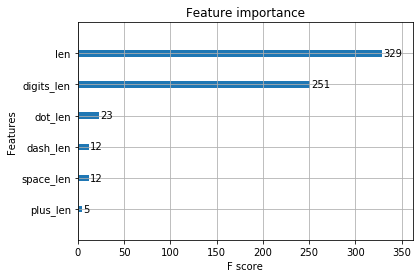

In [13]:
#print(xgb_clf.feature_importances_)
#plt.bar(range(len(xgb_clf.feature_importances_)), xgb_clf.feature_importances_)
#plt.show()

#X_train
plot_importance(xgb_clf)
plt.show()
